### Introduction
We are classifying different architectural styles based on their visual appearance. Our dataset will be images of buildings with different architectural styles. This model can be applicable in several scenarios; for instance, tourists can take photos of a building on the road and get its architectural style in real time. Specifically, this model is designed to recognize architectural styles from different historical eras or different architects' designs.  

We are planning to use supervised learning with a convolutional neural network. We’ll first determine iconic architectural styles in history and scrape the dataset accordingly from the internet. Then, we’ll define our model class based on the number of classes and features, choosing the most compatible convolutional neural network and defining our objective and optimizer according to the model we employed. Finally, we’ll yield a predictive model.

### Importing necessary library

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
%matplotlib inline

### Exploring the dataset

- We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel.   
- Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others 

In [2]:
train = ImageFolder("./dataset-lite-augumented", transform = tt.Compose([
    tt.Resize(224),
    tt.RandomCrop(224),
    tt.ToTensor(),
]))
train_dl = DataLoader(train, 16, shuffle=True, num_workers=2, pin_memory=True)

def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1
        
    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean,std

mean, std = get_mean_std(train_dl)
mean, std

(tensor([0.5094, 0.5159, 0.5085]), tensor([0.2602, 0.2462, 0.2862]))

We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 224 x 224 pixels, and then flip the image horizontally randomly. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

In [3]:
stats = (mean, std)

# Additional data augmentation for training
additional_train_transform = tt.Compose([
    tt.RandomRotation(5),           # Randomly rotate the image by up to 5 degrees
    tt.ColorJitter(brightness=0.1,   # Randomly adjust brightness
                   contrast=0.1,     # Randomly adjust contrast
                   saturation=0.1,   # Randomly adjust saturation
                   hue=0.1),
])

train_transform = tt.Compose([
    tt.Resize(224),
    tt.RandomCrop(224),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    additional_train_transform,
    tt.Normalize(*stats,inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(224),
    tt.RandomCrop(224),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

In [4]:
train = ImageFolder("./dataset-lite-augumented", transform = train_transform)
print(train.classes)
print(len(train))
# splitting the dataset into train and test
train_size = int(0.9 * len(train))
test_size = len(train) - train_size
train_ds, test_ds = random_split(train, [train_size, test_size])
print(len(train_ds), len(test_ds))

['Achaemenid architecture', 'Ancient Egyptian architecture', 'Baroque architecture', 'Byzantine architecture', 'Colonial architecture', 'Deconstructivism', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Russian Revival architecture']
10068
9061 1007


We will split our dataset into three parts:
- train_ds: for training the data.
- valid_ds: for validating our model accuracy.
- test_ds: for testing the trained model.

In [5]:
random_seed = 42
torch.manual_seed(random_seed);

In [6]:
val_size = int(len(train_ds) * 0.1)
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds), len(test_ds)

(8155, 906, 1007)

### Convert labels to one-hot encoding
Load data and one-hot encode the labels.  

In [7]:
train_ds = [(data, label) for data, label in train_ds]
val_ds = [(data, label) for data, label in val_ds]
test_ds = [(data, label) for data, label in test_ds]


In [8]:
# Extract labels from the datasets
train_labels = torch.tensor([label for _, label in train_ds])
val_labels = torch.tensor([label for _, label in val_ds])
test_labels = torch.tensor([label for _, label in test_ds])

# Assuming the number of classes is known (replace with your actual number of classes)
num_classes = len(train.classes)

# Perform one-hot encoding
train_one_hot = torch.nn.functional.one_hot(train_labels, num_classes)
val_one_hot = torch.nn.functional.one_hot(val_labels, num_classes)
test_one_hot = torch.nn.functional.one_hot(test_labels, num_classes)

# PyTorch data loaders with one-hot encoded labels
train_ds_one_hot = list(zip([data for data, _ in train_ds], train_one_hot))
val_ds_one_hot = list(zip([data for data, _ in val_ds], val_one_hot))
test_ds_one_hot = list(zip([data for data, _ in test_ds], test_one_hot))

batch_size = 16  # Set your desired batch size
train_dl_one_hot = DataLoader(train_ds_one_hot, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl_one_hot = DataLoader(val_ds_one_hot, batch_size * 2, num_workers=2, pin_memory=True)
test_dl_one_hot = DataLoader(test_ds_one_hot, batch_size * 2, num_workers=2, pin_memory=True)

In [9]:
# # PyTorch data loaders
# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
# valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
# test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

train_dl = train_dl_one_hot
valid_dl = val_dl_one_hot
test_dl = test_dl_one_hot

Denormalize and visualize part of the dataset.  

In [10]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

C:\Users\alpha\AppData\Local\Temp\ipykernel_3744\1157265081.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means = torch.tensor(means).reshape(1, 3, 1, 1)
C:\Users\alpha\AppData\Local\Temp\ipykernel_3744\1157265081.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)


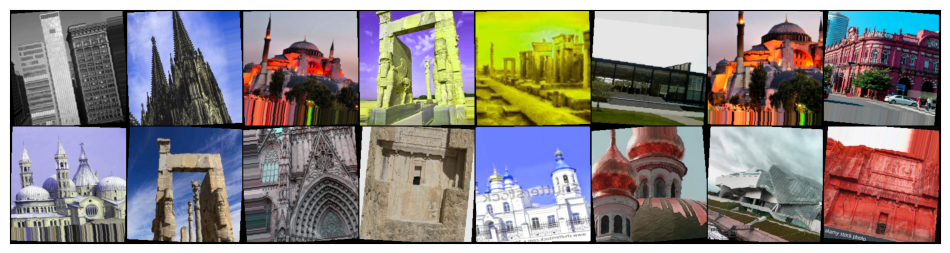

In [11]:
show_batch(train_dl)

Inspect the one-hot encoded labels

In [12]:
# One-hot encode the label for train_ds, val_ds and test_ds

no_of_classes = len(train.classes)

def one_hot_encode(label, num_classes):
    return F.one_hot(torch.tensor(label), num_classes)

# Define a function to update labels in a dataset
def update_labels(dataset, num_classes):
    updated_dataset = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        label = one_hot_encode(label, num_classes)
        updated_dataset.append((image, label))
    return updated_dataset

# Update labels in the training dataset
updated_train_ds = update_labels(train_ds, no_of_classes)

# Update labels in the validation dataset
updated_val_ds = update_labels(val_ds, no_of_classes)

# Update labels in the test dataset
updated_test_ds = update_labels(test_ds, no_of_classes)


In [13]:
train_ds = updated_train_ds
val_ds = updated_val_ds
test_ds = updated_test_ds

# Get one from the train set
image, label = train_ds[0]
print(image.shape, label)

torch.Size([3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


### Utility function and classes

Define few function and classes to move data into gpu, which will boost the training time to 10 times faster even more from cpu


In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

`ImageClassificationBase` is the base class, which calculates the losses and keep track of every epoch

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    
    # Convert one-hot encoded labels to class indices
    _, targets = torch.max(labels, dim=1)
    
    return torch.tensor(torch.sum(preds == targets).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.binary_cross_entropy_with_logits(out, labels.float())
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.binary_cross_entropy_with_logits(out, labels.float())
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc']))

Moving our data into gpu 

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### Building the model

We will extend `ImageClassificationBase` to build several models to train with our dataset
- ResNet5
- ResNet9
- ResNet31
- Pretrained ResNet18

 We've add additional `Dropout` to address overfitting.

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [19]:
class ResNet5(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super(ResNet5, self).__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.5),
                                        nn.Linear(256, num_classes))
        

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [20]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.5),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [21]:
import torch.nn.init as init

class ResNet31(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256), conv_block(256, 256))
        
        self.conv4 = conv_block(256, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512), conv_block(512, 512))
        
        self.conv5 = conv_block(512, 1024, pool=True)
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.res2(out) + out
        out = self.conv4(out)
        out = self.res3(out) + out
        out = self.conv5(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        return out


In [22]:
class PretrainedResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.network = torchvision.models.resnet18(pretrained=True)
        fc_input_size = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(fc_input_size, fc_input_size // 2),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(fc_input_size // 2, num_classes),
            nn.Dropout(0.5),
        )
        
        
    def forward(self, xb):
        return self.network(xb)

### Setup Training
- Configure number of classes
- Choose model

In [23]:
no_of_classes = len(train.classes)
no_of_classes

10

In [24]:
model = to_device(ResNet5(3, no_of_classes), device)
model

ResNet5(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Training the model

We collect important data like training loss, training arruracy and validation loss as well as validation accuracy and plot with tensorboard to monitor training process.

In [25]:
from torch.utils.tensorboard import SummaryWriter

min_validation_loss = 100

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    writer = SummaryWriter()

    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracies = []
        lrs = []
        for batch in train_loader:
            loss, accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(accuracy)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Record & update learning rate
        lrs.append(get_lr(optimizer))
        sched.step()

        # Write to TensorBoard
        writer.add_scalar('Loss/Train', loss.item(), len(train_loader) * epoch + epoch)
        writer.add_scalar('Accuracy/Train', accuracy.item(), len(train_loader) * epoch + epoch)
        writer.add_scalar('LearningRate', get_lr(optimizer), len(train_loader) * epoch + epoch)
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracies).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        # Write to TensorBoard
        writer.add_scalar('Loss/Validation', result['val_loss'], epoch)
        writer.add_scalar('Accuracy/Validation', result['val_acc'], epoch)

        global min_validation_loss
        # Saving the model only if the validation loss decreases
        if result['val_loss'] < min_validation_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model Saved" + " | Minium Loss: " + str(result['val_loss']))
            min_validation_loss = result['val_loss']
    
    # Close TensorBoard writer
    writer.close()

    return history

Test with random weight at the beginning

In [26]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6817563772201538, 'val_acc': 0.09181033819913864}]

Define parameters

In [27]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Start training

In [28]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00050, train_loss: 0.3636, train_accuracy: 0.1628, val_loss: 0.2981, val_acc: 0.2459
Model Saved | Minium Loss: 0.29810041189193726
Epoch [1], last_lr: 0.00082, train_loss: 0.3132, train_accuracy: 0.2306, val_loss: 0.2899, val_acc: 0.2491
Model Saved | Minium Loss: 0.2899179458618164
Epoch [2], last_lr: 0.00132, train_loss: 0.3002, train_accuracy: 0.2551, val_loss: 0.2772, val_acc: 0.3185
Model Saved | Minium Loss: 0.2772398293018341
Epoch [3], last_lr: 0.00199, train_loss: 0.2931, train_accuracy: 0.2853, val_loss: 0.2886, val_acc: 0.2666
Epoch [4], last_lr: 0.00281, train_loss: 0.2901, train_accuracy: 0.2946, val_loss: 0.2734, val_acc: 0.3412
Model Saved | Minium Loss: 0.27336081862449646
Epoch [5], last_lr: 0.00373, train_loss: 0.2878, train_accuracy: 0.3024, val_loss: 0.2880, val_acc: 0.3002
Epoch [6], last_lr: 0.00471, train_loss: 0.2864, train_accuracy: 0.3076, val_loss: 0.2708, val_acc: 0.3528
Model Saved | Minium Loss: 0.2707788944244385
Epoch [7], last_lr:

ValueError: Tried to step 25501 times. The specified number of total steps is 25500

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

### Model Evaluation

In [ ]:
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

In [ ]:
# Show predictions and ground truth
# def show_predictions(dl, model):
#     model.eval()
#     images, labels = next(iter(dl))
#     images = to_device(images, device)
#     labels = to_device(labels, device)
#     outputs = model(images)
#     _, preds = torch.max(outputs, dim=1)
#     print("Ground truth:")
#     print(labels)
#     print("Predictions:")
#     print(preds)
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.set_xticks([]); ax.set_yticks([])
#     print(*stats)
#     mean = torch.tensor(stats[0]).reshape(1, 3, 1, 1)
#     std = torch.tensor(stats[1]).reshape(1, 3, 1, 1)
#     mean = to_device(mean, device)
#     std = to_device(std, device)
#     statss = (mean, std)
#     denorm_images = denormalize(images, *statss)
#     ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))

# show_predictions(test_loader, model)

### Prediction  
Predict with our saved best model  

In [ ]:
# Load the best model
model.load_state_dict(torch.load('resnet31.pth'))

# Evaluate on test dataset
result = evaluate(model, test_loader)
result

In [ ]:
# Show predictions and ground truth on a batch of images
def show_predictions(dl, model):
    model.eval()
    images, labels = next(iter(dl))
    images = to_device(images, device)
    labels = to_device(labels, device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    print("Ground truth:")
    print(labels)
    print("Predictions:")
    print(preds)
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    # print(*stats)
    mean = torch.tensor(stats[0]).reshape(1, 3, 1, 1)
    std = torch.tensor(stats[1]).reshape(1, 3, 1, 1)
    mean = to_device(mean, device)
    std = to_device(std, device)
    statss = (mean, std)
    denorm_images = denormalize(images, *statss)
    ax.imshow(make_grid(denorm_images[:64].cpu(), nrow=8).permute(1, 2, 0).clamp(0,1))

In [ ]:
show_predictions(test_loader, model)